<a href="https://colab.research.google.com/github/hamedmirsadeghi/DeepLearning/blob/main/Validation_regularisation_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [123]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [124]:
# Save the input and target variables
print(diabetes_dataset.keys())
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [125]:
# Normalise the target data (this will make clearer training curves)
targets =( targets - targets.mean() ) / targets.std()


In [126]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)

print(train_data.shape, test_data.shape, train_targets.shape, test_targets.shape)


(397, 10) (45, 10) (397,) (45,)


#### Train a feedforward neural network model

In [127]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential()
    model.add( Dense(128, activation='relu', input_shape = ( train_data.shape[1], )) )
    model.add( Dense(128, activation='relu') )
    model.add( Dense(128, activation='relu') )
    model.add( Dense(128, activation='relu') )
    model.add( Dense(128, activation='relu') )
    model.add( Dense(128, activation='relu') )
    model.add( Dense(1) )
    return model
model = get_model()



In [128]:
# Print the model summary
print(model.summary())


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 128)               1408      
_________________________________________________________________
dense_158 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_159 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_160 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_161 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_162 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_163 (Dense)            (None, 1)               

In [129]:
# Compile the model
model.compile( optimizer= 'adam', loss='mae', metrics=['mae', 'mape'])


In [130]:
# Train the model, with some of the data reserved for validation
history =model.fit(train_data, train_targets, validation_split=0.15, batch_size=64, epochs = 100, verbose=False)


In [131]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets)


2/2 [==============================] - 0s 7ms/step - loss: 0.7893 - mae: 0.7893 - mape: 1282.1791


[0.7893036603927612, 0.7893036603927612, 1282.1790771484375]

#### Plot the learning curves

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

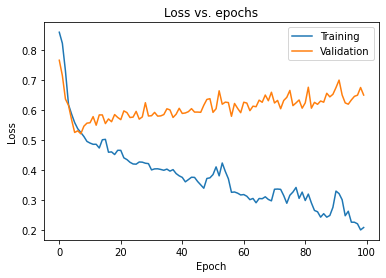

In [133]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [134]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [135]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd), input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [136]:
# Re-build the model with weight decay and dropout layers
model= get_regularised_model(1e-5,0.3)

In [137]:
# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mae'] )


In [138]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100,
                    validation_split =0.15, batch_size = 64, verbose =False)


In [139]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets)


2/2 [==============================] - 0s 7ms/step - loss: 0.6831 - mae: 0.6768


[0.6831248998641968, 0.6767564415931702]

#### Plot the learning curves

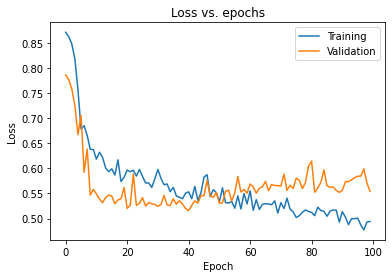

In [140]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [141]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallbacks(Callback):
    def on_train_begin(self, logs = None):
        print("Starting training .....")

    def on_epoch_begin(self, epoch, logs = None):
        print(f"Starting epoch {epoch}")

    def on_train_batch_begin(self, batch, logs = None):
        print(f"Starting batch {batch}")

    def on_train_batch_end(self, batch, logs = None):
        print(f"finished batch {batch}")
    
    def on_epoch_end(self, epoch, logs = None):
        print(f"Finshe epoch {epoch}")

    def on_train_end(self, logs = None):
        print("Finished training .....")


class TestingCallbacks(Callback):
    def on_test_begin(self, logs = None):
        print("Starting testing .....")

    def on_test_batch_begin(self, batch, logs = None):
        print(f"Starting batch {batch}")

    def on_test_batch_end(self, batch, logs = None):
        print(f"finished batch {batch}")
    
    def on_test_end(self, logs = None):
        print("Finished testing .....")

class PredictionCallbacks(Callback):
    def on_predict_begin(self, logs = None):
        print("Starting predicting .....")

    def on_predict_batch_begin(self, batch, logs = None):
        print(f"Starting batch {batch}")

    def on_predict_batch_end(self, batch, logs = None):
        print(f"finished batch {batch}")
    
    def on_predict_end(self, logs = None):
        print("Finished predicting .....")

In [142]:
# Re-build the model
model = get_regularised_model(1e-9, 0.3)


In [143]:
# Compile the model
model.compile( optimizer= 'adam', loss= 'mse')


#### Train the model with the callback

In [144]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallbacks()])


Starting training .....
Starting epoch 0
Starting batch 0
finished batch 0
Starting batch 1
finished batch 1
Starting batch 2
finished batch 2
Starting batch 3
finished batch 3
Finshe epoch 0
Starting epoch 1
Starting batch 0
finished batch 0
Starting batch 1
finished batch 1
Starting batch 2
finished batch 2
Starting batch 3
finished batch 3
Finshe epoch 1
Starting epoch 2
Starting batch 0
finished batch 0
Starting batch 1
finished batch 1
Starting batch 2
finished batch 2
Starting batch 3
finished batch 3
Finshe epoch 2
Finished training .....


In [145]:
# Evaluate the model
model.evaluate(test_data, test_targets, callbacks=[TestingCallbacks()])


Starting testing .....
Starting batch 0
1/2 [==============>...............] - ETA: 0s - loss: 1.0747finished batch 0
Starting batch 1
finished batch 1
2/2 [==============================] - 0s 7ms/step - loss: 1.0275
Finished testing .....


1.0275177955627441

In [146]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallbacks()])


Starting predicting .....
Starting batch 0
finished batch 0
Starting batch 1
finished batch 1
Finished predicting .....


array([[-0.00505724],
       [-0.02971398],
       [ 0.02261007],
       [ 0.02897156],
       [-0.02624836],
       [-0.03880414],
       [-0.00548938],
       [ 0.04019446],
       [-0.06387947],
       [-0.05938331],
       [ 0.03283057],
       [ 0.02367973],
       [-0.04518079],
       [ 0.0185403 ],
       [ 0.00236097],
       [-0.019371  ],
       [ 0.02672976],
       [ 0.01794016],
       [ 0.01566404],
       [ 0.02578042],
       [-0.02881988],
       [-0.0138903 ],
       [-0.0365619 ],
       [-0.00646863],
       [ 0.00225403],
       [-0.01865503],
       [-0.04709233],
       [-0.06053998],
       [-0.00734899],
       [-0.03532501],
       [ 0.00858461],
       [-0.01579474],
       [-0.06190869],
       [ 0.02593108],
       [ 0.04289319],
       [-0.02185944],
       [-0.05805627],
       [ 0.03239252],
       [-0.00658759],
       [ 0.01374688],
       [-0.01794496],
       [ 0.00118301],
       [-0.05790754],
       [-0.03674304],
       [ 0.00243218]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [165]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss = 'mse')
unreg_history = unregularised_model.fit(train_data, train_targets,
                                        validation_split = 0.15, batch_size = 64,
                                        epochs = 100,
                                        verbose = False)


In [166]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose=0)


0.9982702732086182

In [162]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile( optimizer = 'adam', loss = 'mse')
reg_history = regularised_model.fit(train_data, train_targets, epochs=100,
                                    validation_split = 0.15, batch_size = 64,
                                    verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [163]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=0)


0.5532736778259277

#### Plot the learning curves

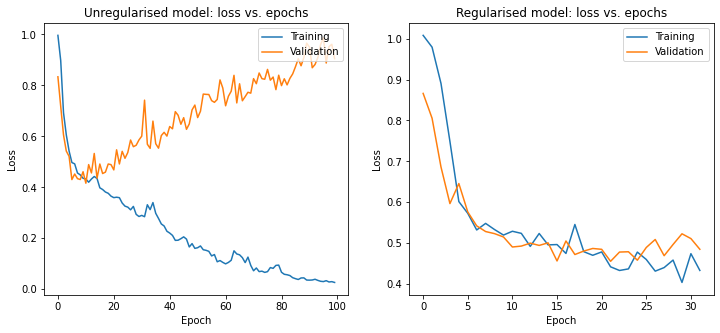

In [167]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()